# Multi-output Gaussian Processes in GPflow

This notebook will show how to construct a multi-output GP model using GPflow. We will consider a regression problem for functions $f: \mathbb{R}^D \rightarrow \mathbb{R}^P$. We assume that the dataset is of the form $(X, f_1), \dots, (X, f_P)$, i.e. we observe all the outputs for a given input location. For the case where we do fully observe all the outputs for a given input please see the [coregionalisation notebook](./coregionalisation.ipynb).

Here we assume a model of the form: 
$$f(x) = W g(x),$$
where $g(x) \in \mathbb{R}^L$, $f(x) \in \mathbb{R}^P$ and $W \in \mathbb{R}^{P \times L}$. We assume that the outputs of $g$ are uncorrelated, and by *mixing* them with $W$ they become correlated. In this notebook, we illustrate how to build this model using SVGP for $g$, which scales well with the numbers of datapoints and outputs. 

Here we have two cases for $g$:
1. The output dimensions of $g$ share the same kernel.
2. Each output of $g$ has a separate kernel.


In addition, we have two further subcases for the inducing inputs of $g$:
1. The $g$'s share the same inducing inputs.
2. Each output of $g$ has its own set of inducing inputs.

Notation:
$
\newcommand{\GP}{\mathcal{GP}}
\newcommand{\NN}{\mathcal{N}}
\newcommand{\LL}{\mathcal{L}}
\newcommand{\RR}{\mathbb{R}}
\newcommand{\EE}{\mathbb{E}}
\newcommand{\valpha}{\boldsymbol\alpha}
\newcommand{\vf}{\mathbf{f}}
\newcommand{\vF}{\mathbf{F}}
\newcommand{\vg}{\mathbf{g}}
\newcommand{\vW}{\mathbf{W}}
\newcommand{\vI}{\mathbf{I}}
\newcommand{\vZ}{\mathbf{Z}}
\newcommand{\vu}{\mathbf{u}}
\newcommand{\vU}{\mathbf{U}}
\newcommand{\vX}{\mathbf{X}}
\newcommand{\vY}{\mathbf{Y}}
\newcommand{\identity}{\mathbb{I}}
$
- $X \in \mathbb{R}^{N \times D}$ the input
- $Y \in \RR^{N \times P}$ the output
- $k_{1..L}$, $L$ kernels on $\RR^{N \times D}$
- $g_{1..L}$, $L$ independent $\GP$s  with $g_l \sim \GP(0,k_l)$
- $f_{1..P}$, $P$ correlated  $\GP$s  with $\vf = \vW \vg$ 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gpflow as gpf

import gpflow.multioutput.kernels as mk
import gpflow.multioutput.features as mf
%matplotlib inline

MAXITER = gpf.test_util.notebook_niter(int(15e1))

## Generate synthetic data
We create a utility function to generate synthetic data, we assume that:

In [2]:
N = 100 # number of points
D = 1  # number of input dimensions
M = 20  # number of inducing points
L = 2  # number of latent GPs
P = 3  # number of observations = output dimensions

In [3]:
def generate_data(N=100):
    X = np.random.rand(N)[:, None] * 10 - 5  # Inputs = N x D
    G = np.hstack((0.5 * np.sin(3 * X) + X, 3.0 * np.cos(X) - X)) # G = N x L
    W = np.array([[0.5, -0.3, 1.5], [-0.4, 0.43, 0.0]])  # L x P
    F = np.matmul(G, W)  # N x P
    Y = F + np.random.randn(*F.shape) * [0.2, 0.2, 0.2]
    
    return X, Y

In [4]:
X, Y = generate_data(N)

We create a utility function for plotting:

In [5]:
def plot_model(m, lower=-6, upper=6):
    pX = np.linspace(lower, upper, 100)[:, None]
    pY, pYv = m.predict_y(pX)
    if pY.ndim == 3:
        pY = pY[:, 0, :]
    plt.plot(m.X.value, m.Y.value, 'x')
    plt.gca().set_prop_cycle(None)
    plt.plot(pX, pY)
    for i in range(pY.shape[1]):
        top = pY[:, i] + 2.0 * pYv[:, i] ** 0.5
        bot = pY[:, i] - 2.0 * pYv[:, i] ** 0.5
        plt.fill_between(pX[:, 0], top, bot, alpha=0.3)
    plt.xlabel('X')
    plt.ylabel('f')

## Modelling the outputs $f(x)$ directly
In the three examples below, we will show how to model the outputs of the model $f(x)$ directly. Mathematically, this case is equivalent to having:
$$
f(x) = I g(x),
$$
i.e. $W = I$ and $P = L$.

### 1. Shared Independent MOK & Shared Independent Features

We will use the same kernel to model each of the output dimensions.
We will use the same inducing inputs in each of the approximations.

In [6]:
gpf.reset_default_graph_and_session()

In [7]:
# create multioutput kernel
kernel = mk.SharedIndependentMok(gpf.kernels.RBF(1) + gpf.kernels.Linear(1), output_dimensionality=P) 
# initialisation of inducing input locations (first M points of training inputs)
Z = X[:M,...].copy() 
# create multioutput features from Z
feature = mf.SharedIndependentMof(gpf.features.InducingPoints(Z)) 

In [8]:
# create SVGP model as usual and optimize
m = gpf.models.SVGP(X, Y, kernel, gpf.likelihoods.Gaussian(), feat=feature) 

opt = gpf.train.ScipyOptimizer()
opt.minimize(m, disp=True, maxiter=MAXITER)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 139.370100
  Number of iterations: 150
  Number of functions evaluations: 165


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 139.370100
  Number of iterations: 150
  Number of functions evaluations: 165


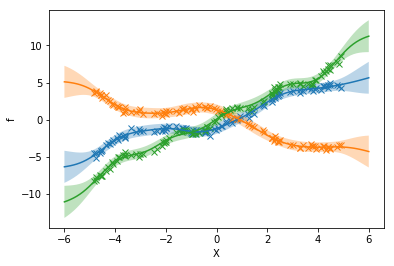

In [9]:
# Plot predictions and observations
plot_model(m)

### 2. Separate Independent MOK & Shared Independent Features

In [10]:
gpf.reset_default_graph_and_session()

In [11]:
# Create list of kernels for each output
kern_list = [gpf.kernels.RBF(D) + gpf.kernels.Linear(1) for _ in range(P)]
# Create multioutput kernel from kernel list
kernel = mk.SeparateIndependentMok(kern_list)
# initialisation of inducing input locations (first M points of training inputs)
Z = X[:M,...].copy() 
# create multioutput features from Z
feature = mf.SharedIndependentMof(gpf.features.InducingPoints(Z)) 

In [12]:
# create SVGP model as usual and optimize
m = gpf.models.SVGP(X, Y, kernel, gpf.likelihoods.Gaussian(), feat=feature)

opt = gpf.train.ScipyOptimizer()
opt.minimize(m, disp=True, maxiter=MAXITER)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 85.811403
  Number of iterations: 150
  Number of functions evaluations: 182


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 85.811403
  Number of iterations: 150
  Number of functions evaluations: 182


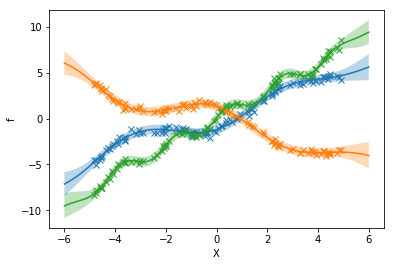

In [13]:
plot_model(m)

### 3. Separate Independent Kernel & Separate Independent Features

In [14]:
gpf.reset_default_graph_and_session()

In [15]:
# Create list of kernels for each output
kern_list = [gpf.kernels.RBF(D) + gpf.kernels.Linear(1) for _ in range(P)]
# Create multioutput kernel from kernel list
kernel = mk.SeparateIndependentMok(kern_list)
# initialisation of inducing input locations, one set of locations per output
Zs = [X[np.random.permutation(len(X))[:M],...].copy() for _ in range(P)]
# initialise as list inducing features
feature_list = [gpf.features.InducingPoints(Z) for Z in Zs]
# create multioutput features from feature_list
feature = mf.SeparateIndependentMof(feature_list)

In [16]:
# create SVGP model as usual and optimize
m = gpf.models.SVGP(X, Y, kernel, gpf.likelihoods.Gaussian(), feat=feature)

opt = gpf.train.ScipyOptimizer()
opt.minimize(m, disp=True, maxiter=MAXITER)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 84.681520
  Number of iterations: 150
  Number of functions evaluations: 173


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 84.681520
  Number of iterations: 150
  Number of functions evaluations: 173


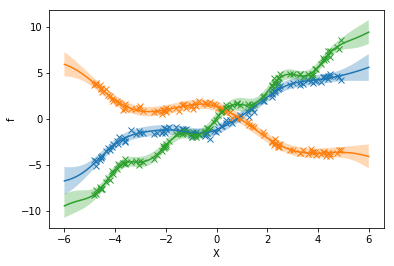

In [17]:
plot_model(m)

The plot below shows that we use different inducing *inputs* in each output dimension.

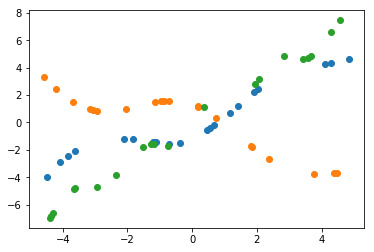

In [18]:
for i in range(len(m.feature.feat_list)):
    q_mu_unwhitened, q_var_unwhitened = m.predict_f(m.feature.feat_list[i].Z.value)
    plt.plot(m.feature.feat_list[i].Z.value, q_mu_unwhitened[:, [i]], "o")

## Modelling $f(x)$ by doing inference in the $g$ space
### Mixed Kernel & Uncorrelated Features 

Remember the general case: $f(x) = W g(x)$, where $g(x) \in \mathbb{R}^L$, $f(x) \in \mathbb{R}^P$ and $W \in \mathbb{R}^{P \times L}$, where $L \leq P$.
We assume that the outputs of $g$ are uncorrelated, and by *mixing* them with $W$ they become correlated.
With this setup we perform the optimal routine to calculate the conditional. Namely, calculate the conditional of the uncorrelated latent $g$ and afterwards project the mean and variance using the mixing matrix: $\mu_f = W \mu_g$ and $\Sigma_f = W~\Sigma_g W^\top$

- $ K_{uu} = L \times M \times M $
- $ K_{uf} = L \times M \times N $

In [19]:
gpf.reset_default_graph_and_session()

In [20]:
# Create list of kernels for each output
kern_list = [gpf.kernels.RBF(D) + gpf.kernels.Linear(D) for _ in range(L)]
# Create multioutput kernel from kernel list
kernel = mk.SeparateMixedMok(kern_list, W=np.random.randn(P, L)) # Notice that we initialise the mixing matrix W
# initialisation of inducing input locations (first M points of training inputs)
Z = X[:M,...].copy()
# create multioutput features from Z
feature = mf.MixedKernelSharedMof(gpf.features.InducingPoints(Z))

In [21]:
# initialise mean of variational posterior to be of shape MxL
q_mu = np.zeros((M, L)) 
# initialise \sqrt(Σ) of variational posterior to be of shape LxMxM
q_sqrt = np.repeat(np.eye(M)[None, ...], L, axis=0) * 1.0 

# create SVGP model as usual and optimize
m = gpf.models.SVGP(X, Y, kernel, gpf.likelihoods.Gaussian(), feat=feature, q_mu=q_mu, q_sqrt=q_sqrt)

opt = gpf.train.ScipyOptimizer()
opt.minimize(m, disp=True, maxiter=MAXITER)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 158.335733
  Number of iterations: 150
  Number of functions evaluations: 173


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 158.335733
  Number of iterations: 150
  Number of functions evaluations: 173


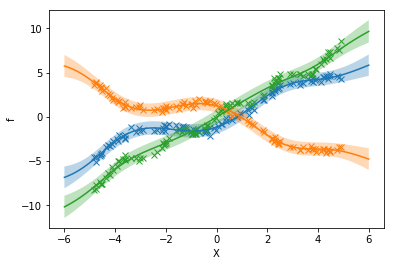

In [22]:
plot_model(m)

## Illustration of GPflow's Multi-output Capabilities

### Multi Output Kernels class diagram
![new_multioutput_gp_kernels.png](./new_multioutput_gp_kernels.png)




### Multi Output Features class diagram

![new_multioutput_gp_features.png](./new_multioutput_gp_features.png)

### Notes:
- MixedKernelSeparateMof is not implemented but can easily be added to the framework

### Shape of Kuu and Kuf and the underlying conditional code depends on Mof and Mok classes used

| Feature                | Kernel                        | Kuu           | Kuf           | conditional                     | note                                                                                                                                                                                                            |
|------------------------|-------------------------------|---------------|---------------|---------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| InducingPoints         | Mok  | MxPxMxP | MxPxNxP | fully_correlated_conditional    | This is the default. Will be very inefficient for certain kernels. In this case q_mu and q_sqrt are 1 x MP and 1 x MP x MP                                                                                                                                              |
| SharedIndependentMof   | SharedIndependentMok          | M x M         | M x N         | base_conditional                | These two classes are in a sense redundant as we can achieve the same behaviour using the single output Kernel and InducingFeature classes. They are added for illustrative purposes. But thanks to the conditional dispatch the most efficient code path will be used                          |
| SeparateIndependentMof | SharedIndependentMok          | P x M x M     | P x M x N     | P x base_conditional            | We loop P times over the base_conditional                                                                                                                                                                       |
| SharedIndependentMof   | SeparateIndependentMok        | P x M x M     | P x M x N     | P x base_conditional            | We loop P times over the base_conditional                                                                                                                                                                                                                 |
| SeparateIndependentMof | SeparateIndependentMok        | P x M x M     | P x M x N     | P x base_conditional            | We loop P times over the base_conditional                                                                                                                                                                                                                |
| SharedIndependentMof   | SeparateMixedKernel           | L x M x M     | M x L x N x P | independent_interdomain_conditional | inducing outputs live in g-space                                                                                                                                                                                |
| SeparateIndependentMof | SeparateMixedKernel           | L x M x M     | M x L x N x P | independent_interdomain_conditional | very similar as above                                                                                                                                                                                           |
| MixedKernelSharedMof   | SeparateMixedKernel           | L x M x M     | L x M x N     | base_conditional                 | This is the most efficient implementation for MixedKernels.  The inducing outputs live in g-space. Here we use the output of the base conditional and project the mean and covariance with the mixing matrix W. |

## Further Reading:
- [Coregionalisation](./coregionalisation.ipynb), which details other GPflow features for multi-output prediction without fully observed outputs.